# Solar

In [2]:
#|code-fold: true
#|output: false
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import matplotlib.ticker as ticker

import numpy as np
import random
from pathlib import Path
from tqdm import tqdm
import torch
torch.manual_seed(10) 
import torch.optim as optim
import torch.nn as nn
import platform
from PIL import Image
from PIL.ImageStat import Stat
import datetime
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, RandomApply, ColorJitter, ToPILImage
import ipyplot
from torchmetrics import JaccardIndex
from torchmetrics.functional import jaccard_index
from processing import BigImage, prep_data, get_unlabeled_tensors, get_labeled_tensors, get_weights
from evaluate import convert_class_mask_to_rgb_image
import datetime
import json
from constants import ROOT, RUNS_FOLDER


from step_by_step import StepByStep, InverseNormalize, load_tensor, get_means_and_stdevs 
from categorize import check_for_missing_files, LABELS, show_image, overlay_two_images
from models import Segnet
plt.style.use('fivethirtyeight')

from evaluate import display_images, evaluate_unlabeled

def get_current_datetime():
    return datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data processing

In [3]:
proj_dir = Path('.').resolve().parent
data_dir = proj_dir / 'data'
batch_size = 32
n_channels = 3
shape = (3, 256, 256)
title_mapping = {'background': 0, 'commonrack': 1, 'commonpanel': 2, 'denserack': 3, 'densepanel': 4}
n_classes = len(title_mapping)

jitter = ColorJitter(brightness=(0.2, 1.0), contrast=(0.3, 1.0))  # jitter will change every time it is called
applier = RandomApply(torch.nn.ModuleList([jitter]), p=0.3)

In [4]:
labeled_tensor_x, labeled_tensor_y, labeled_idx_map = get_labeled_tensors(data_dir, title_mapping)
train_loader, val_loader, val_idx_map, normalizer, val_composer, weights = prep_data(labeled_tensor_x, 
                                                                                     labeled_tensor_y, 
                                                                                     labeled_idx_map, 
                                                                                     applier, 
                                                                                     n_classes,
                                                                                     batch_size=batch_size)
unlabeled_tensor_x, unlabeled_tensor_y, unlabeled_idx_map =  get_unlabeled_tensors(data_dir, shape)

100%|██████████| 2038/2038 [00:06<00:00, 330.81it/s]


# Training

In [7]:
segnet = Segnet(n_channels=n_channels, n_classes=n_classes)
optimizer = optim.Adam(segnet.parameters(), lr=3e-4)

torch.manual_seed(17)
sbs = StepByStep(segnet, optimizer, nn.CrossEntropyLoss(weight=weights))
sbs.set_loaders(train_loader, val_loader)

In [13]:
run_name = 'five_class_segnet_all_pixels_gpu'    
run_folder = Path(RUNS_FOLDER) / (get_current_datetime() + '_' + run_name)
Path(run_folder).mkdir(exist_ok=True, parents=True)

In [34]:
sbs.train(20)

Failed to set loader seed.


100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


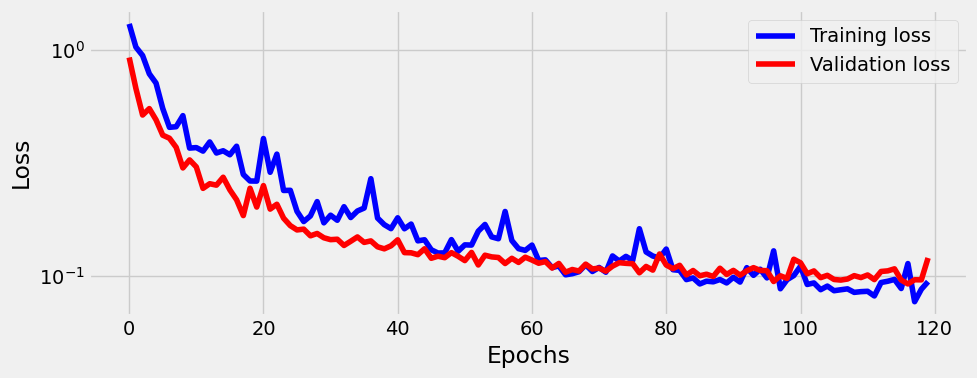

In [35]:
_ = sbs.plot_losses()

# Evaluation

In [36]:
print(sbs.get_metric(jaccard_index))
sbs.save_checkpoint(run_folder / (get_current_datetime() + '_' + 'checkpoint_jaccard_index_' + f'{sbs.metric:.3f}' + '.tar'))

100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

0.52339774


In [29]:
val_loader_iter = iter(val_loader)
batch_idx = -1

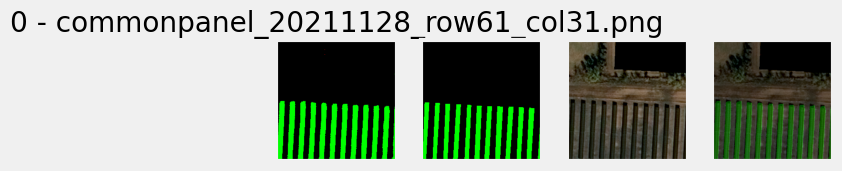

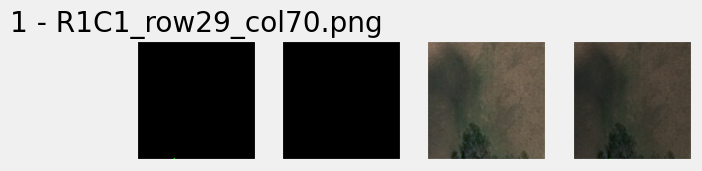

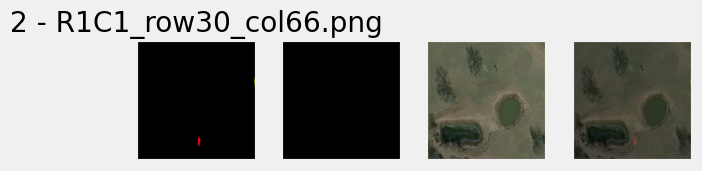

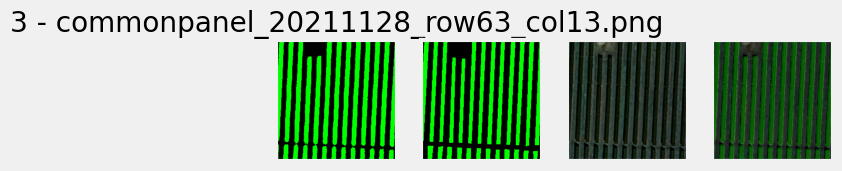

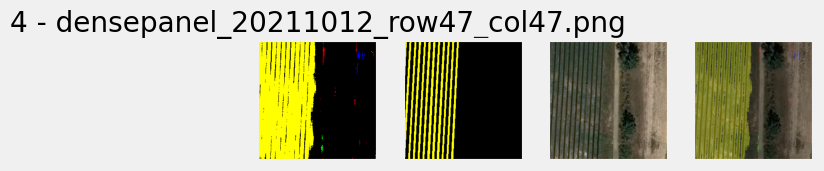

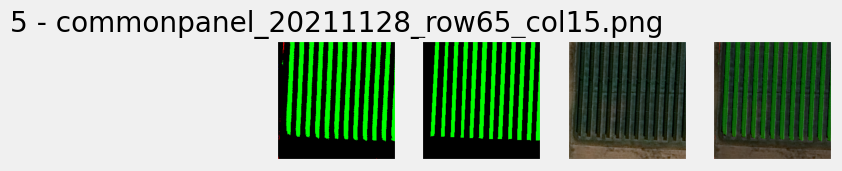

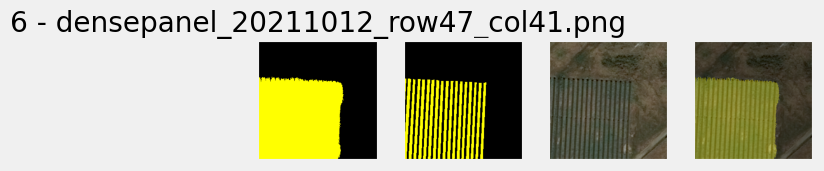

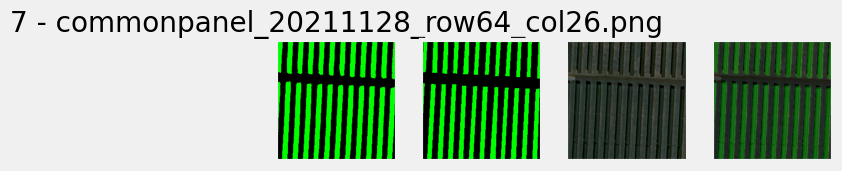

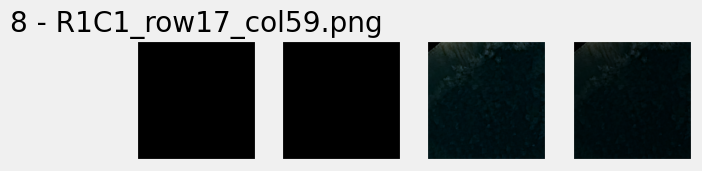

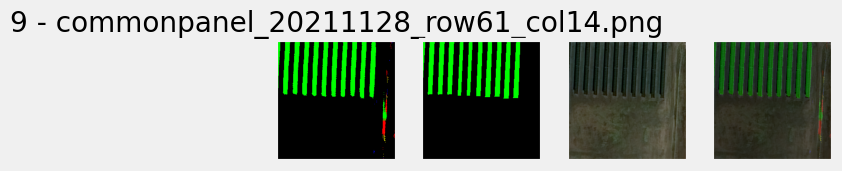

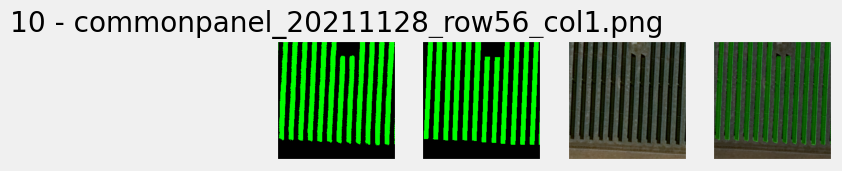

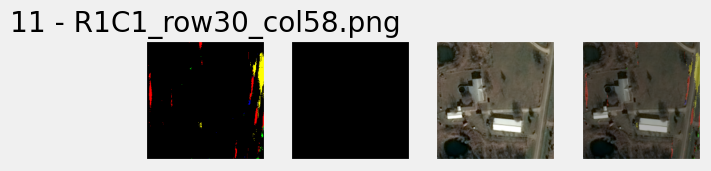

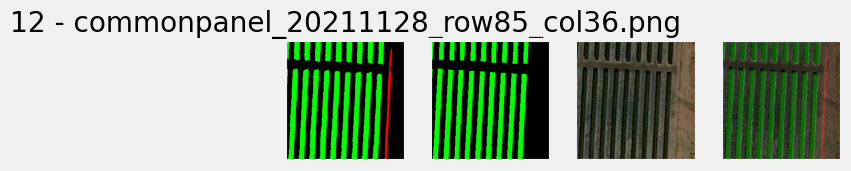

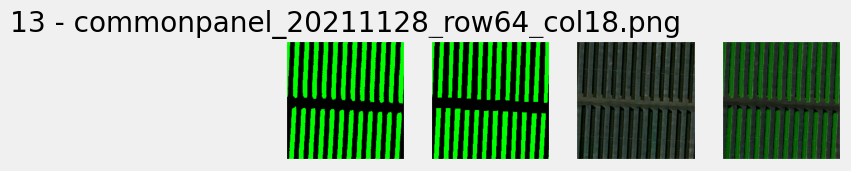

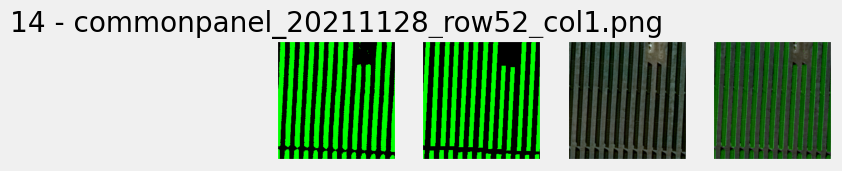

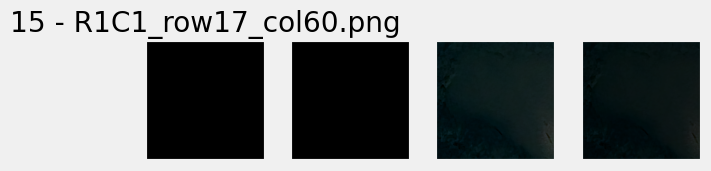

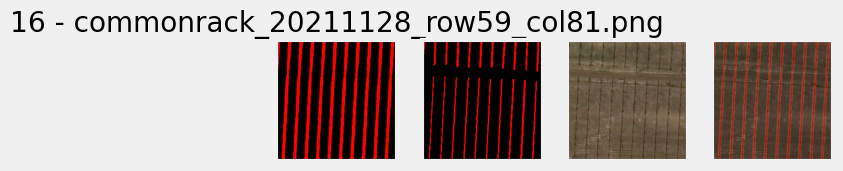

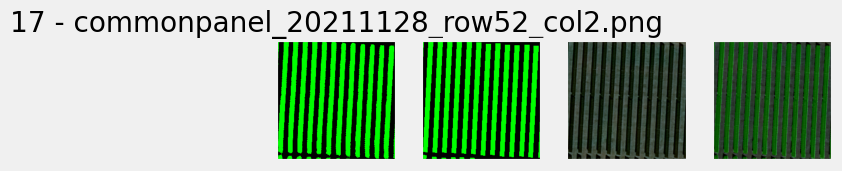

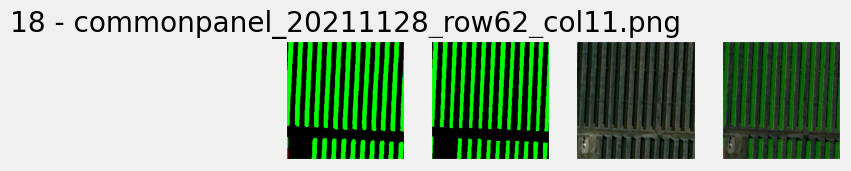

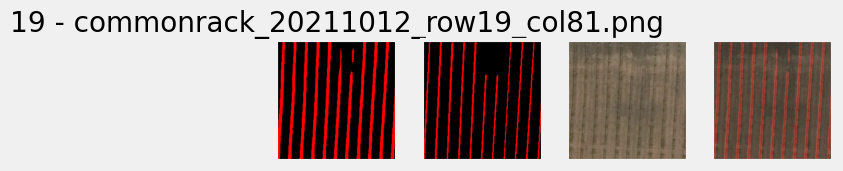

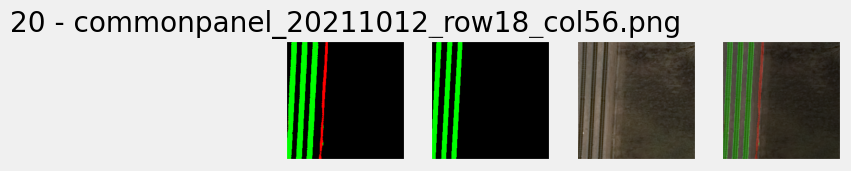

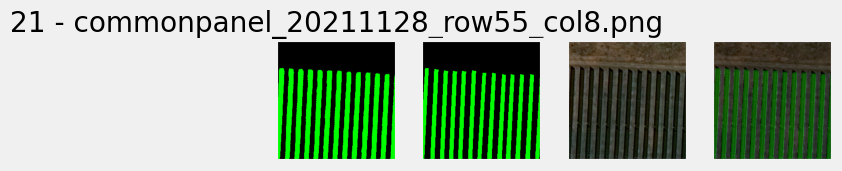

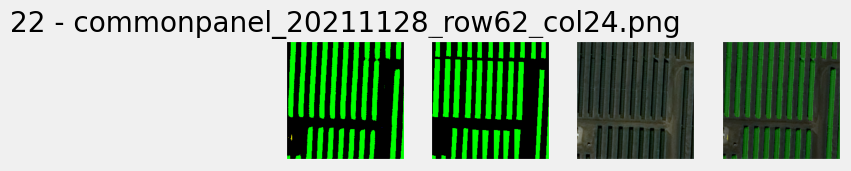

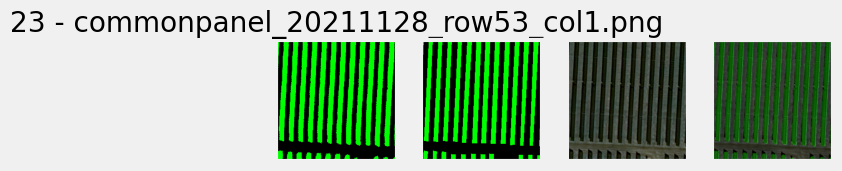

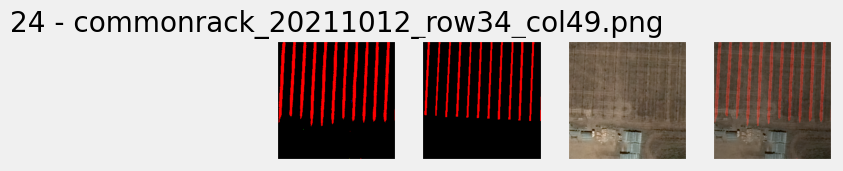

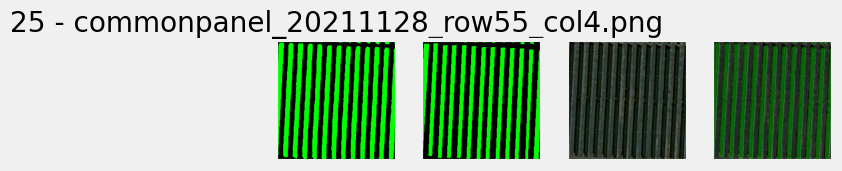

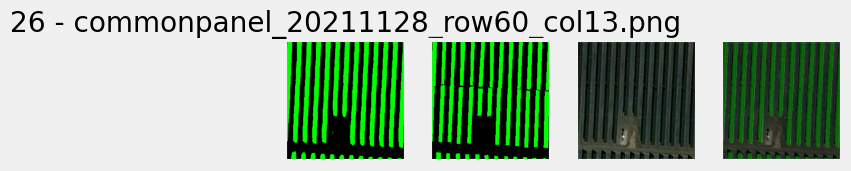

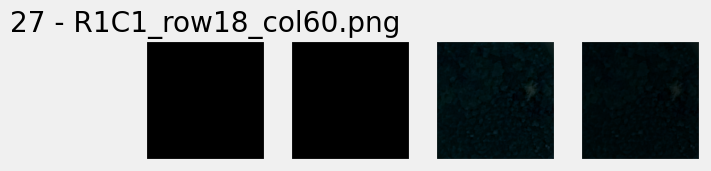

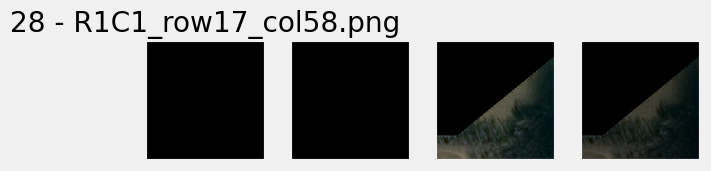

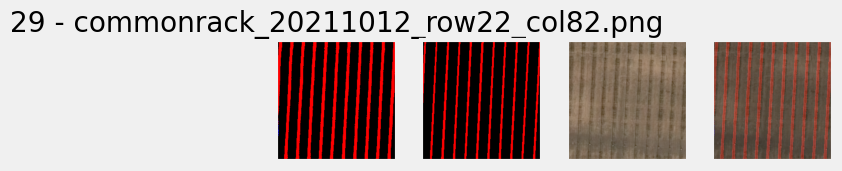

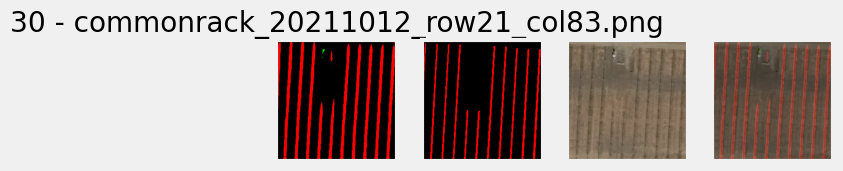

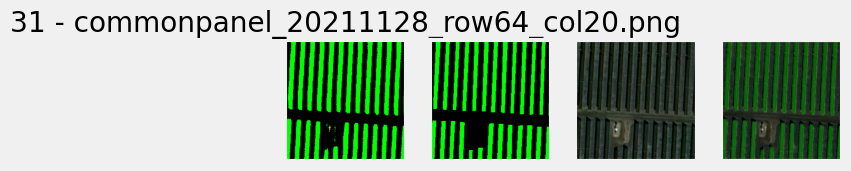

In [30]:
x_val, y_val = next(val_loader_iter)
batch_idx += 1
y_pred = sbs.predict(x_val, to_numpy=False).argmax(1)
display_images(x_val, y_val, y_pred, n_classes, normalizer, 
               idx_map=val_idx_map, idx_offset=batch_idx*batch_size)

In [32]:
evaluate_unlabeled(unlabeled_tensor_x, unlabeled_tensor_y, val_composer, n_classes, normalizer, sbs, run_folder, unlabeled_idx_map)

100%|██████████| 64/64 [02:10<00:00,  2.04s/it]


Expect 1-2 minutes ...
File was not found, using defaults.


2038it [00:01, 1125.89it/s]


Done stitching to: /home/runs/2023_01_24_07_39_five_class_segnet_all_pixels_gpu/R1C1_predicted.png
Expect 1-2 minutes ...
File was not found, using defaults.


2038it [00:05, 394.34it/s]


Done stitching to: /home/runs/2023_01_24_07_39_five_class_segnet_all_pixels_gpu/R1C1_overlayed.png
